In [87]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from tqdm import tqdm
from nltk import word_tokenize
from nltk import pos_tag
from nltk import bigrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
RANDOM_SEED = 42

In [22]:
train_df = pd.read_csv('Data/WikiLarge_Train.csv')

In [23]:
pos_bar = {
    'J': 'a',
    'N': 'n',
    'R': 'r',
    'V': 'v'
}

In [24]:
stop = set(stopwords.words('english'))
lem = WordNetLemmatizer()

tokens = []
for s in train_df['original_text']:
    tokens.append(word_tokenize(s))

keeps = []
for s in tokens:
    keeps.append([w for w in s if w.lower() not in stop and w.isalpha()])
    
pos = []
for s in keeps:
    pos.append([w for w in pos_tag(s) if w[0].isalpha() and w[1] != ''])
    
lemma = []
for s in pos:
    tmp = []
    for w in s:
        if pos_bar.get(w[1][0], None):
            tmp.append(lem.lemmatize(word=w[0], pos=pos_bar[w[1][0]]))
            
    if len(tmp) == 0:
        lemma.append([])
    else:
        lemma.append(tmp)
    
bigram = []
for s in lemma:
    for b in list(bigrams(s)):
        bigram.append(b)

#### New Features

In [25]:
df = train_df

In [41]:
x = [np.max([len(w) for w in i]) for i in keeps if len(i) > 0 else 0]

In [39]:
max(x[0])

10

In [46]:
df['word_count'] = [len(i) for i in keeps]
df['noun_count'] = [len([w[0] for w in s if w[1].startswith('N')]) for s in pos]
df['verb_count'] = [len([w[0] for w in s if w[1].startswith('V')]) for s in pos]
df['adj_count'] = [len([w[0] for w in s if w[1].startswith('J')]) for s in pos]
df['adv_count'] = [len([w[0] for w in s if w[1].startswith('F')]) for s in pos]
df['cnoun_count'] = [len([w[0] for w in s if w[1]=='NN' or w[1]=='NNS']) for s in pos]
df['pnoun_count'] = [len([w[0] for w in s if w[1]=='NNP']) for s in pos]

df['avg_word_length'] = [np.mean([len(w) for w in i]) for i in keeps]
df['avg_noun_length'] = [np.mean([len(w[0]) for w in s if w[1].startswith('N')]) for s in pos]
df['avg_verb_length'] = [np.mean([len(w[0]) for w in s if w[1].startswith('V')]) for s in pos]
df['avg_adj_length'] = [np.mean([len(w[0]) for w in s if w[1].startswith('J')]) for s in pos]
df['avg_adv_length'] = [np.mean([len(w[0]) for w in s if w[1].startswith('F')]) for s in pos]
df['avg_cnoun_length'] = [np.mean([len(w[0]) for w in s if w[1]=='NN' or w[1]=='NNS']) for s in pos]
df['avg_pnoun_length'] = [np.mean([len(w[0]) for w in s if w[1]=='NNP']) for s in pos]
                                
df['max_word_length'] = [np.max([len(w) for w in i]) if len(i) > 0 else 0 for i in keeps]
df['max_noun_length'] = [np.max([len(w[0]) if w[1].startswith('N') else 0 for w in s]) if len(s) > 0 else 0 for s in pos]
df['max_verb_length'] = [np.max([len(w[0]) if w[1].startswith('V') else 0 for w in s]) if len(s) > 0 else 0 for s in pos]
df['max_adj_length'] = [np.max([len(w[0]) if w[1].startswith('J') else 0 for w in s]) if len(s) > 0 else 0 for s in pos]
df['max_adv_length'] = [np.max([len(w[0]) if w[1].startswith('F') else 0 for w in s]) if len(s) > 0 else 0 for s in pos]
df['max_cnoun_length'] = [np.max([len(w[0]) if w[1]=='NN' or w[1]=='NNS' else 0 for w in s]) if len(s) > 0 else 0 for s in pos]
df['max_pnoun_length'] = [np.max([len(w[0]) if w[1]=='NNP' else 0 for w in s]) if len(s) > 0 else 0 for s in pos]

In [47]:
G = nx.Graph(bigram)
dc = dict(G.degree)

In [48]:
df['betweenness'] = [np.mean([dc.get(c,0) for c in s]) for s in lemma]

C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
df.head()

,original_text,label,word_count,noun_count,verb_count,adj_count,adv_count,cnoun_count,pnoun_count,avg_word_length,...,avg_cnoun_length,avg_pnoun_length,max_word_length,max_noun_length,max_verb_length,max_adj_length,max_adv_length,max_cnoun_length,max_pnoun_length,betweenness
0,There is manuscript evidence that Austen conti...,1,18,12,2,2,0,6,6,5.722222,...,7.166667,4.666667,10,10,9,4,0,10,6,1250.611111
1,"In a remarkable comparative analysis , Mandaea...",1,13,8,1,3,0,3,5,7.615385,...,6.666667,6.400000,12,8,12,11,0,8,8,242.692308
2,"Before Persephone was released to Hermes , who...",1,19,8,7,2,0,6,2,6.631579,...,7.000000,5.500000,11,11,9,10,0,11,6,758.411765
3,Cogeneration plants are commonly found in dist...,1,27,17,5,3,0,17,0,6.925926,...,6.764706,NaN,12,12,8,10,0,12,0,1070.259259
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,9,8,0,1,0,3,5,6.888889,...,4.000000,8.400000,11,11,0,8,0,4,11,1776.444444


In [136]:
df_clean = df.dropna()

In [137]:
print(len(df))
print(len(df_clean))

416768
2859


In [138]:
features = ['word_count','avg_word_length','noun_count','verb_count',
            'adj_count','adv_count','cnoun_count','pnoun_count','betweenness']

X = np.array(df_clean[features])
y = np.array(df_clean['label'])

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.62      0.33      0.43       211
           1       0.69      0.88      0.77       361

    accuracy                           0.68       572
   macro avg       0.65      0.60      0.60       572
weighted avg       0.66      0.68      0.65       572



In [141]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [142]:
pca = PCA(n_components=X.shape[1], random_state=42)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [143]:
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 36.61548214,  54.10037207,  66.50630255,  77.93463159,
        86.33266279,  93.65116165,  99.76483216,  99.98951975,
       100.        ])

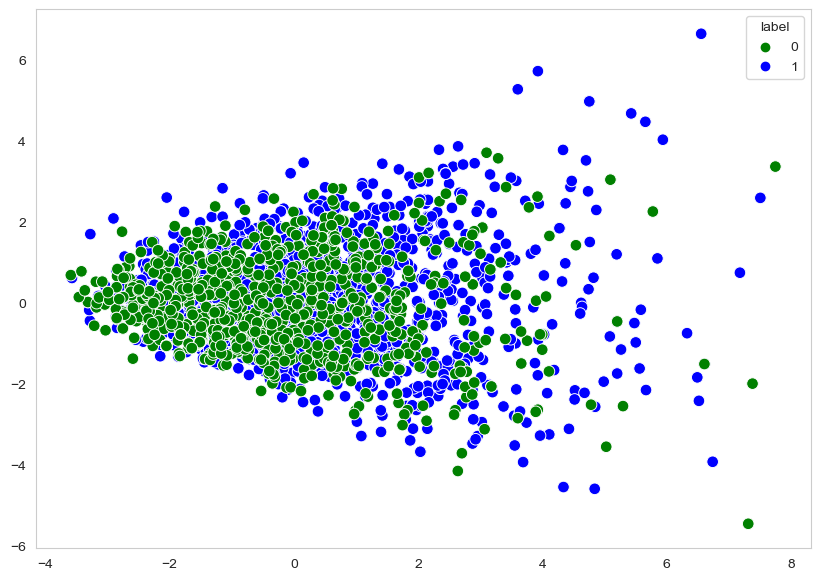

In [144]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=df_clean['label'], palette=['green','blue'])
plt.show()

#### Additional Features

In [145]:
features = ['word_count','noun_count','verb_count','adj_count','adv_count','cnoun_count','pnoun_count','avg_word_length','avg_noun_length',
            'avg_verb_length','avg_adj_length','avg_adv_length','avg_cnoun_length','avg_pnoun_length','max_word_length','max_noun_length',
            'max_verb_length','max_adj_length','max_adv_length','max_cnoun_length','max_pnoun_length','betweenness']

X = np.array(df_clean[features])
y = np.array(df_clean['label'])

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.57      0.31      0.40       211
           1       0.68      0.86      0.76       361

    accuracy                           0.66       572
   macro avg       0.63      0.59      0.58       572
weighted avg       0.64      0.66      0.63       572



In [148]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [149]:
pca = PCA(n_components=X.shape[1], random_state=42)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [150]:
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 24.83253363,  38.20190802,  48.83977755,  57.16083347,
        65.30409472,  72.12225323,  78.47308833,  82.85442454,
        86.66472889,  90.24885951,  93.3474111 ,  95.95871512,
        97.02573958,  97.84524316,  98.55550758,  98.98677199,
        99.31685394,  99.63927492,  99.80424149,  99.91114129,
        99.99603998, 100.        ])

<AxesSubplot:>

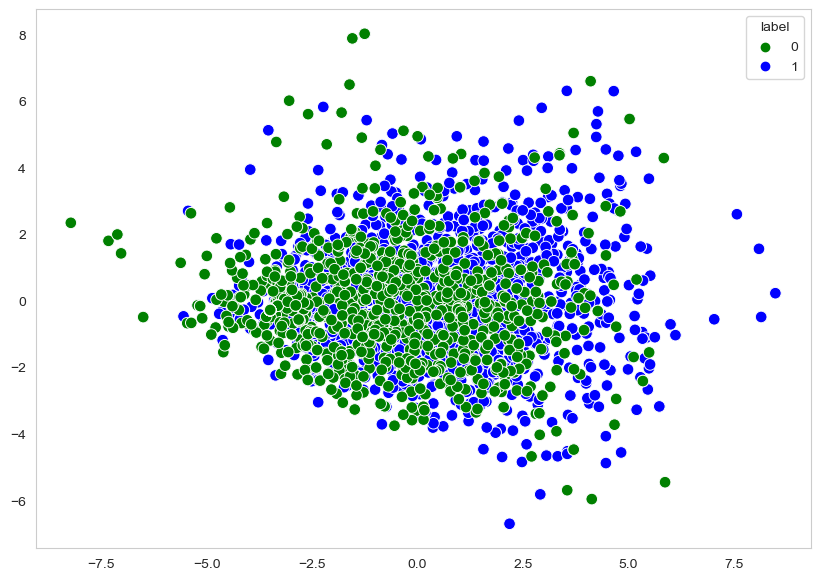

In [151]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=df_clean['label'], palette=['green','blue'])

In [152]:
plt.figure(figsize=(10,7))
sns.(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=df_clean['label'], palette=['green','blue'])

SyntaxError: invalid syntax (3284328993.py, line 2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=df_clean['label'], marker='.')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()